# Gravity sparse inversion with constructor function

In [1]:
import discretize
import harmonica as hm
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
from simpeg.maps import IdentityMap
from simpeg.potential_fields.gravity import (
    Point,
    Simulation3DIntegral,
    SourceField,
    Survey,
)
from simpeg.utils import depth_weighting, model_builder

import inversion_ideas as ii

## Define synthetic data with two prisms

In [2]:
prisms = [
    (-60, -40, -10, 10, -70, -50),
    (40, 60, -10, 10, -70, -50),
]
densities = np.array([-200, 200])  # SI units

region = (-100, 100, -100, 100)
shape = (31, 31)
height = 0
coordinates = vd.grid_coordinates(region, shape=shape, extra_coords=height)

In [3]:
gz = hm.prism_gravity(coordinates, prisms, densities, field="g_z")
gz *= -1  # Invert sign to work with upward component

# Add noise
stderr = vd.maxabs(gz) * 0.01
gz += np.random.default_rng(seed=51).normal(scale=stderr, size=gz.shape)

print(f"{stderr=}")

stderr=np.float64(2.5745854651805945e-05)


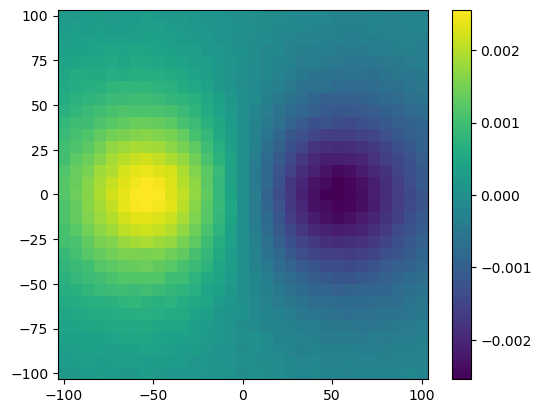

In [4]:
tmp = plt.pcolormesh(*coordinates[:2], gz)
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

In [5]:
gz.size

961

## Define SimPEG simulation

In [6]:
# h = [(5.0, 40)]
h = [(10.0, 20)]
mesh = discretize.TensorMesh(h=[h, h, h], origin="CCN")
mesh

TensorMesh: 8,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     20       -100.00        100.00     10.00     10.00    1.00
   y     20       -100.00        100.00     10.00     10.00    1.00
   z     20       -200.00          0.00     10.00     10.00    1.00

In [7]:
locations = np.vstack(tuple(c.ravel() for c in coordinates)).T
receivers = Point(locations, components="gz")
source = SourceField(receiver_list=[receivers])
survey = Survey(source)

In [8]:
simulation_simpeg = Simulation3DIntegral(mesh, survey=survey, rhoMap=IdentityMap(mesh))

In [9]:
def block_corners(prism):
    p0 = np.array([prism[0], prism[2], prism[4]])
    p1 = np.array([prism[1], prism[3], prism[5]])
    return p0, p1

In [10]:
model = np.zeros(mesh.n_cells)
densities_gcc = densities * 1e-3
print(densities_gcc)

for prism, density in zip(prisms, densities_gcc, strict=True):
    p0, p1 = block_corners(prism)
    model = model_builder.add_block(mesh.cell_centers, model, p0, p1, density)

[-0.2  0.2]


(<matplotlib.collections.QuadMesh at 0x7ff34142e5d0>,)

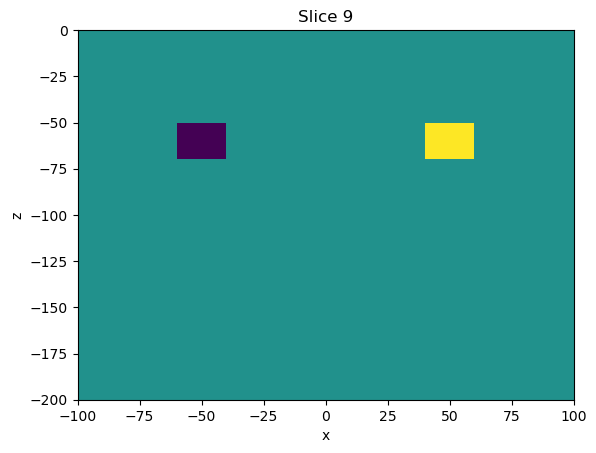

In [11]:
mesh.plot_slice(model, normal="Y", slice_loc=0)

In [12]:
dpred = simulation_simpeg.dpred(model)

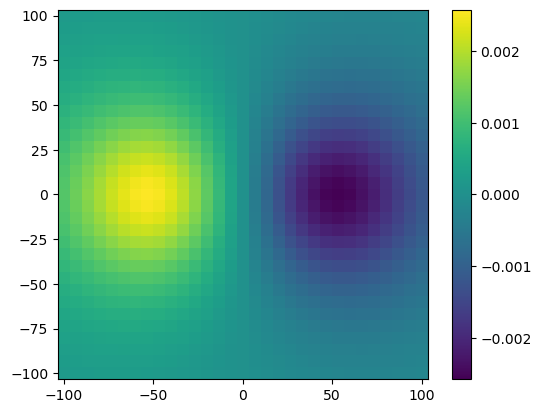

In [13]:
tmp = plt.pcolormesh(*coordinates[:2], dpred.reshape(coordinates[0].shape))
plt.gca().set_aspect("equal")
plt.colorbar(tmp)
plt.show()

## Sparse gravity inversion

Wrap SimPEG's simulation into a child of the new `Simulation` class:

In [14]:
simulation = ii.wrap_simulation(simulation_simpeg, store_jacobian=True)

In [15]:
uncertainties = stderr * np.ones(gz.size)
data_misfit = ii.DataMisfit(gz.ravel(), uncertainties, simulation)

In [16]:
depth_weights = depth_weighting(mesh, 0) ** 2
sparse_smallness = ii.SparseSmallness(
    mesh=mesh,
    norm=1,
    cell_weights=depth_weights,
)

In [17]:
initial_model = np.zeros(simulation.n_params)

sparse_inversion = ii.create_sparse_inversion(
    data_misfit,
    sparse_smallness,
    starting_beta=1e4,
    initial_model=initial_model,
    minimizer=ii.conjugate_gradient,
    preconditioner="jacobi",
    max_iterations=100,
)

In [18]:
model = sparse_inversion.run()

Output()

INFO: 🎉 Inversion successfully finished due to stopping criteria.


In [19]:
sparse_inversion.stopping_criteria.info(model)

[x] ObjectiveChanged
├── Condition: |φ(m) - φ(m_prev)| <= max(|φ(m_prev)| * rtol, atol)
├── |φ(m) - φ(m_prev)| = 9.11e-02
├── |φ(m_prev)|        = 9.72e+01
├── rtol               = 1.00e-03
└── atol               = 0.00e+00

In [20]:
log = sparse_inversion.log.to_pandas()
log

,beta,phi_d,phi_m,beta * phi_m,phi,chi,IRLS,IRLS threshold,model_norm_relative_diff
iter,,,,,,,,,
0,10000.000000,1.667546e+06,0.000000,0.000000,1.667546e+06,1735.219131,inactive,1.000000e-08,NaN
1,10000.000000,6.397443e+02,0.238191,2381.911795,3.021656e+03,0.665707,inactive,1.000000e-08,inf
2,10000.000000,1.157237e+05,26.499910,264999.102497,3.807228e+05,120.420059,active,3.317265e-03,110.254792
3,3777.641031,3.328264e+04,39.308827,148494.639359,1.817773e+05,34.633342,active,3.317265e-03,0.483357
4,1452.921466,8.267373e+03,49.299604,71628.452820,7.989583e+04,8.602885,active,3.317265e-03,0.254161
...,...,...,...,...,...,...,...,...,...
63,3.855102,6.995587e+02,97.479035,375.791634,1.075350e+03,0.727949,active,8.612112e-07,0.001290
64,3.855102,6.997626e+02,97.363398,375.345838,1.075108e+03,0.728161,active,6.889690e-07,0.001186
65,3.855102,6.999331e+02,97.256968,374.935541,1.074869e+03,0.728338,active,5.511752e-07,0.001093


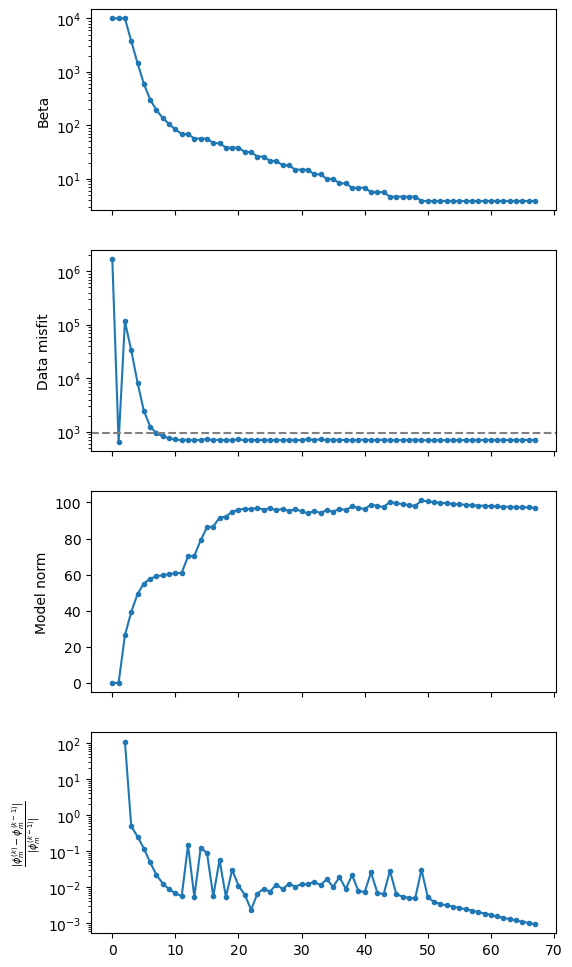

In [21]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(6, 12))
axes[0].plot(log.index, log.beta, ".-")
axes[0].set_yscale("log")
axes[0].set_ylabel("Beta")

axes[1].plot(log.index, log.phi_d, ".-")
axes[1].axhline(data_misfit.n_data, linestyle="--", color="grey")
axes[1].set_ylabel("Data misfit")
axes[1].set_yscale("log")

axes[2].plot(log.index, log.phi_m, ".-")
axes[2].set_ylabel("Model norm")

axes[3].plot(log.index, log.model_norm_relative_diff, ".-")
axes[3].set_ylabel(r"$\frac{ |\phi_m^{(k)} - \phi_m^{(k-1)}| }{ |\phi_m^{(k-1)}| }$")
axes[3].set_yscale("log")

plt.show()

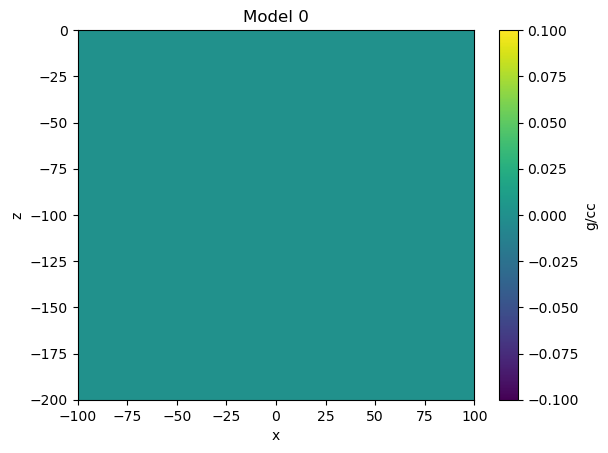

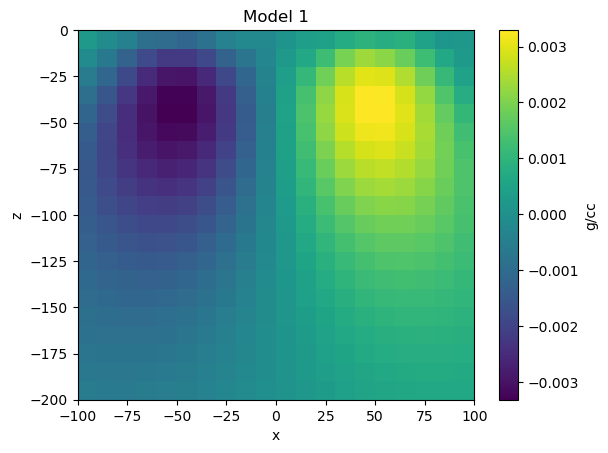

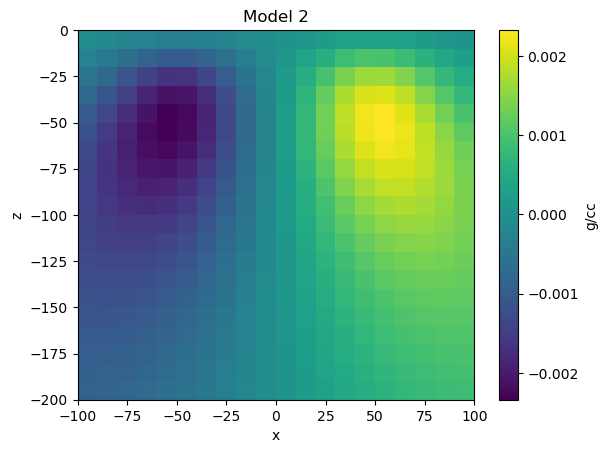

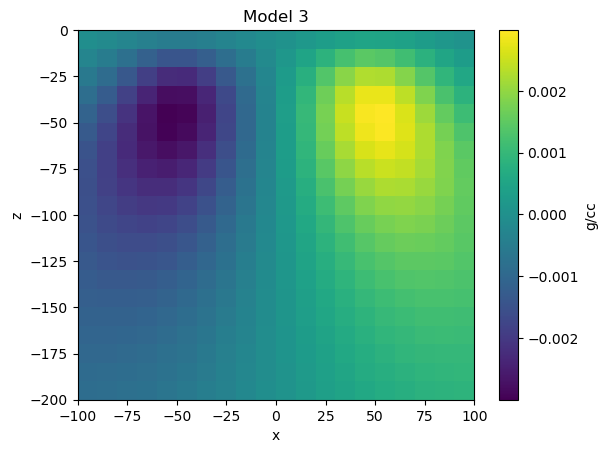

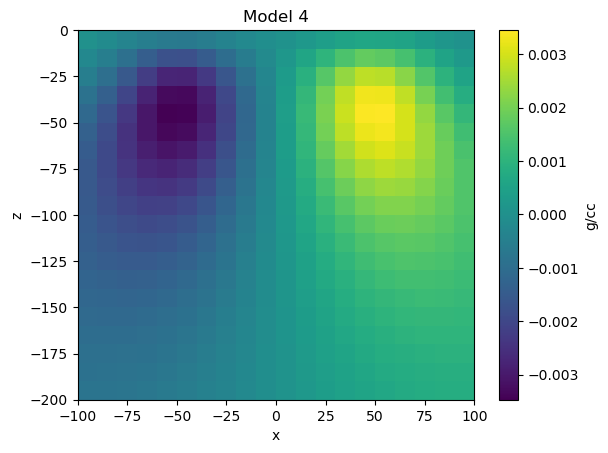

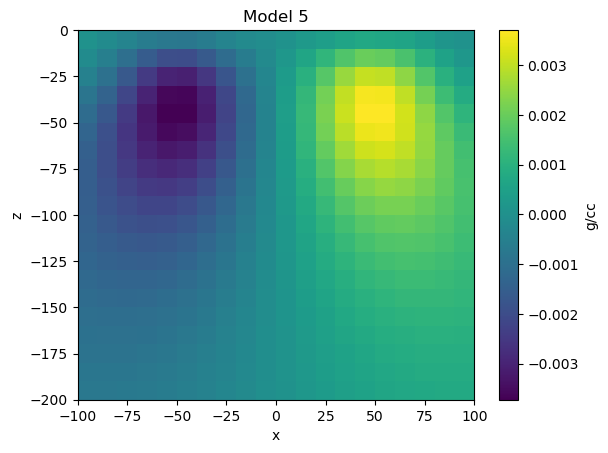

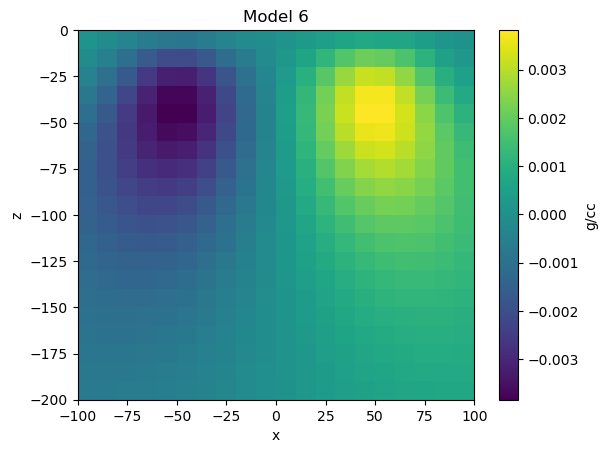

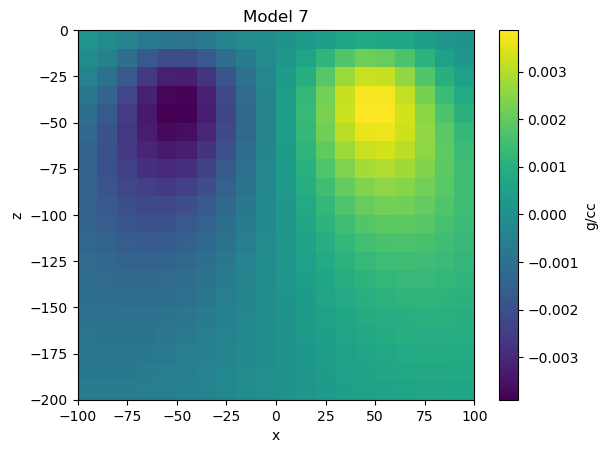

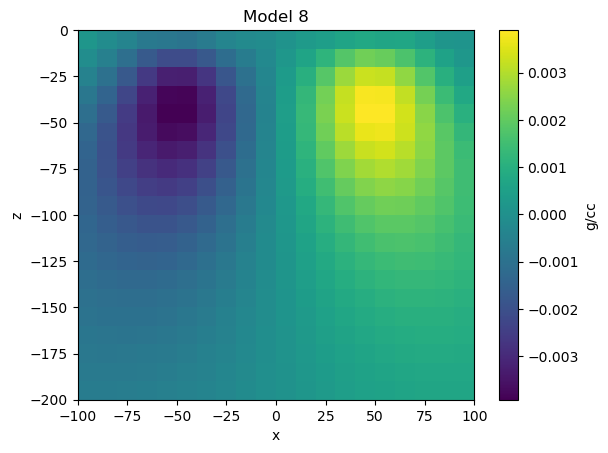

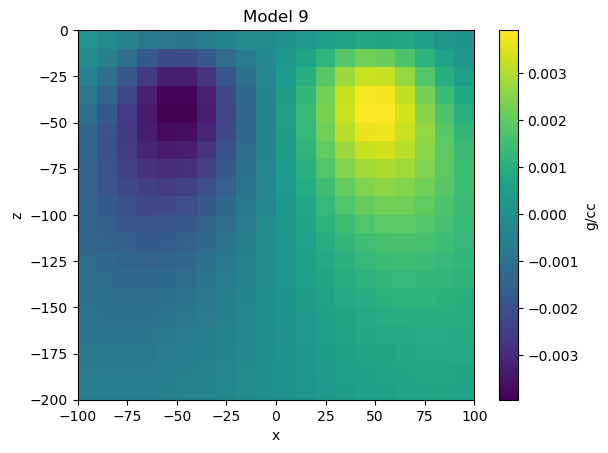

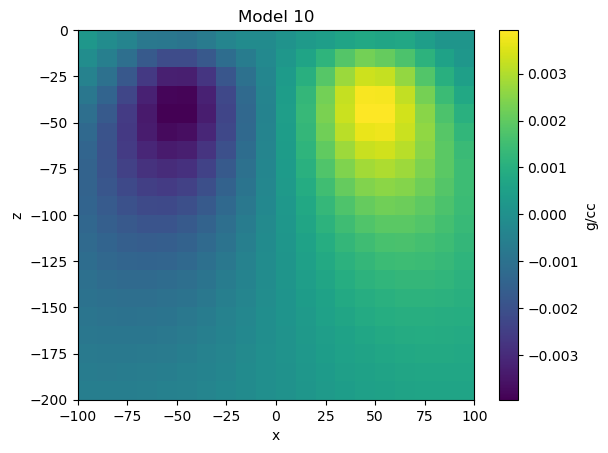

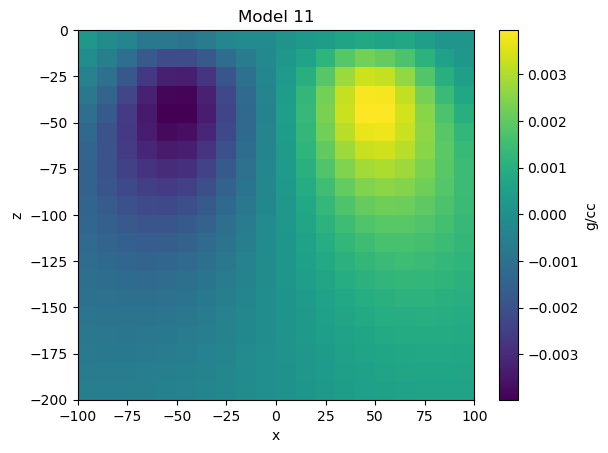

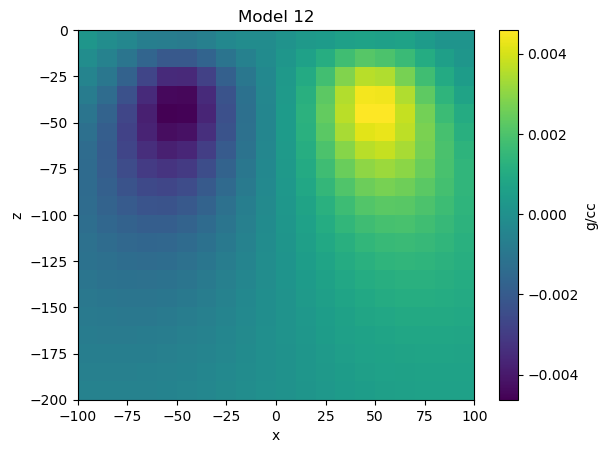

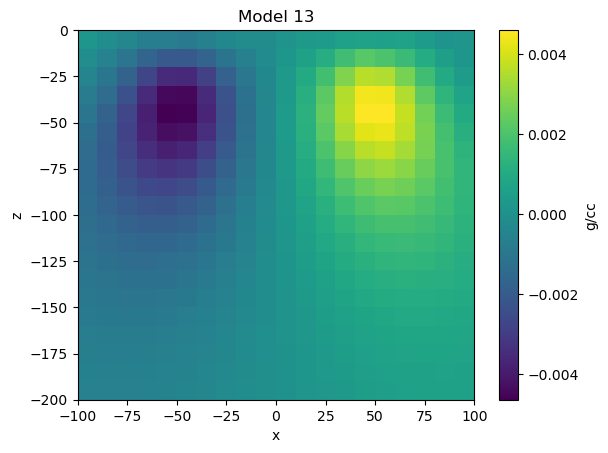

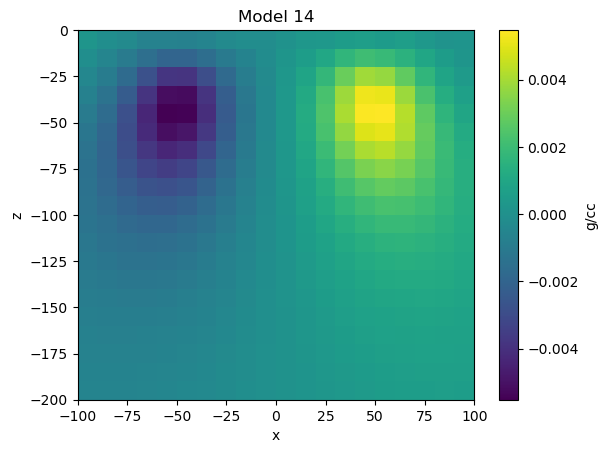

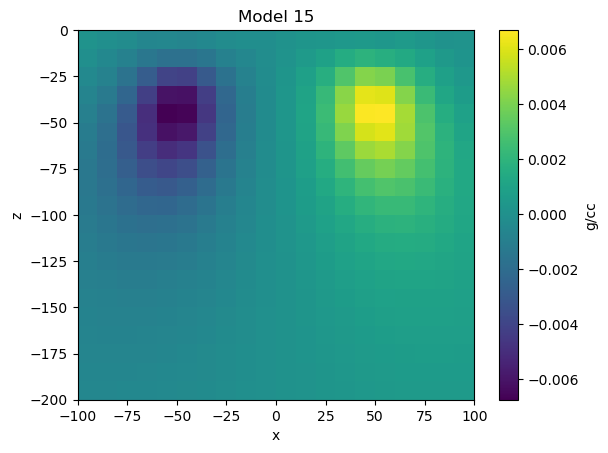

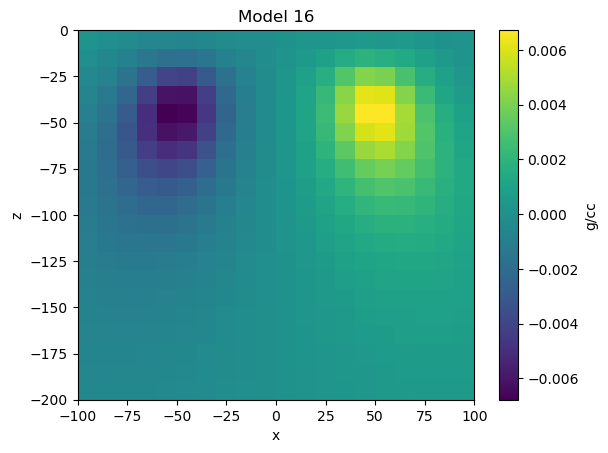

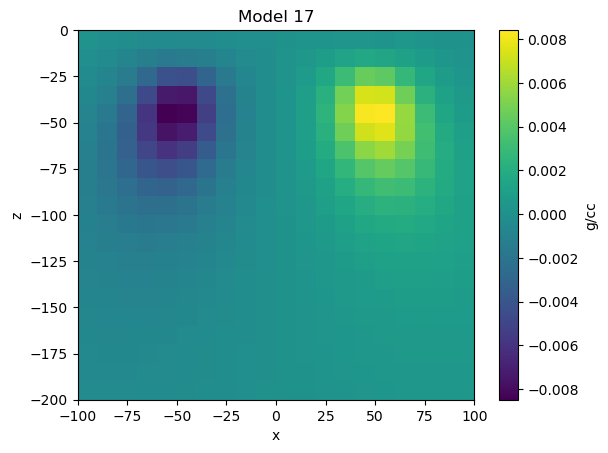

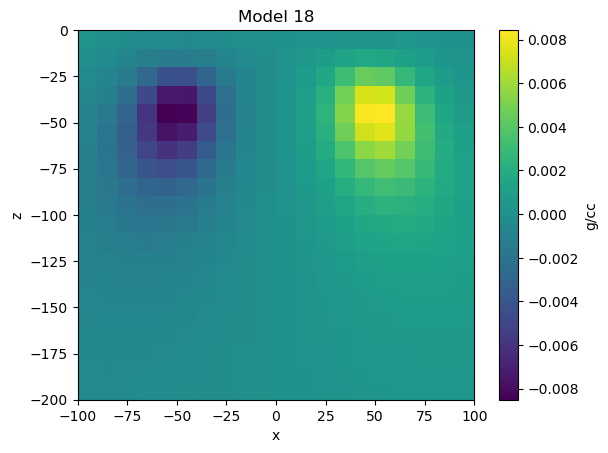

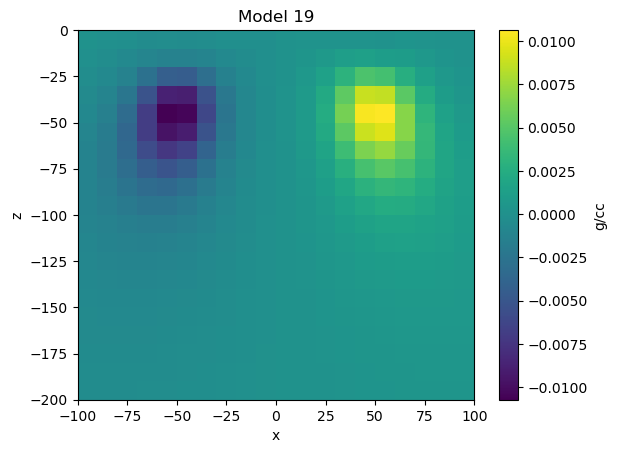

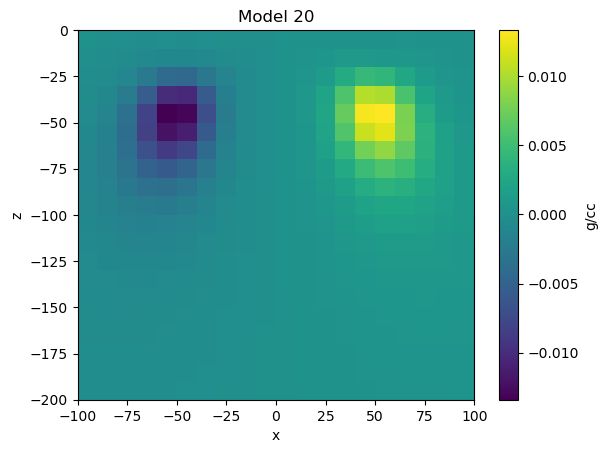

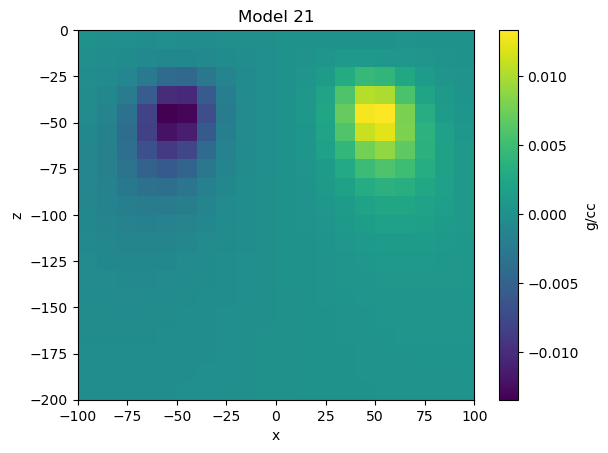

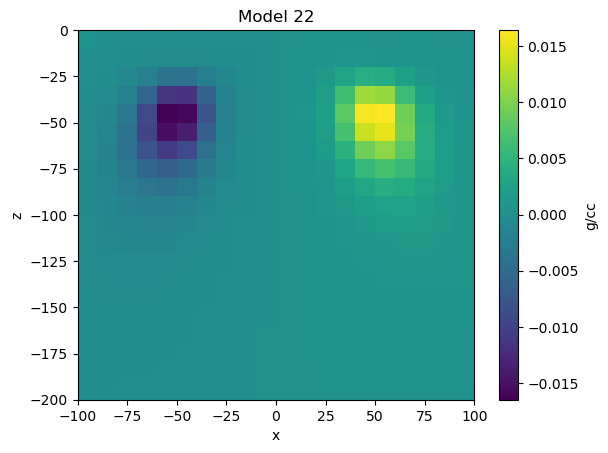

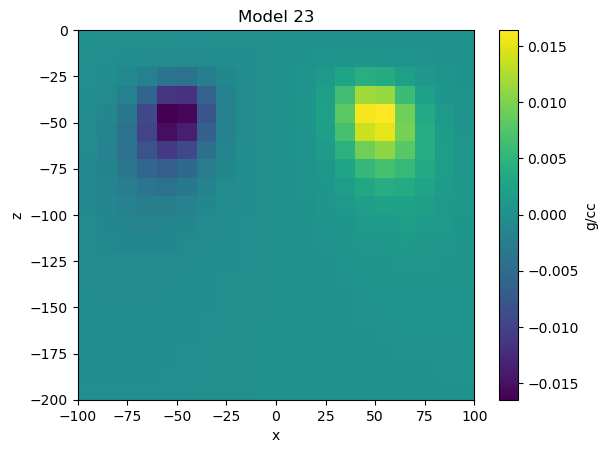

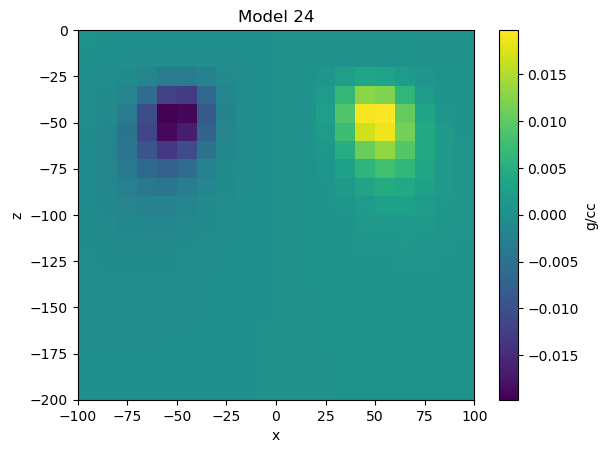

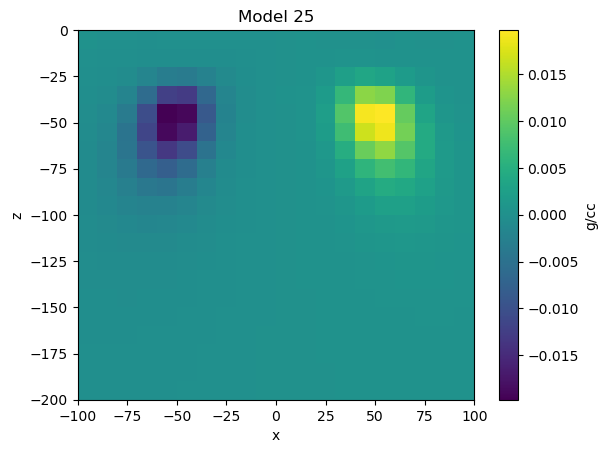

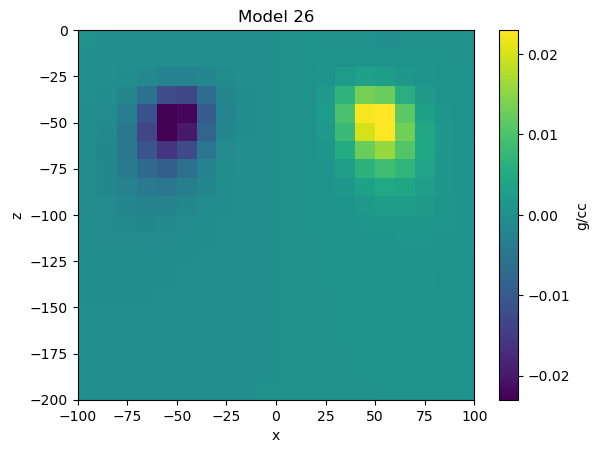

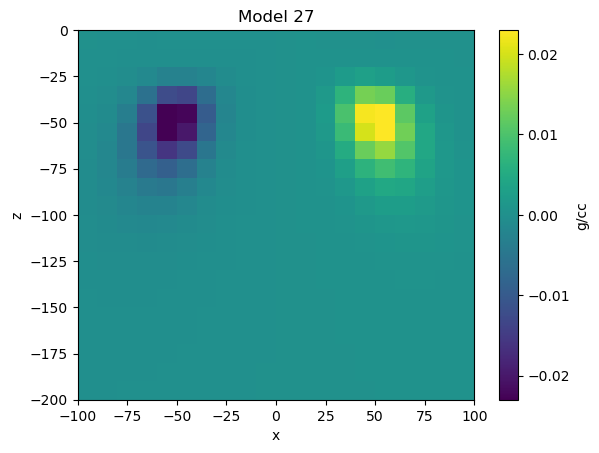

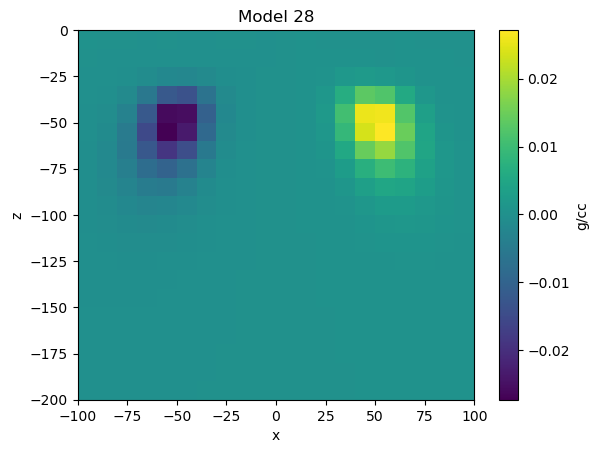

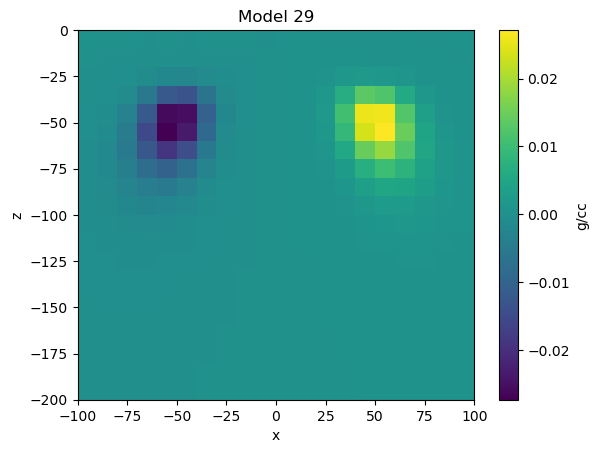

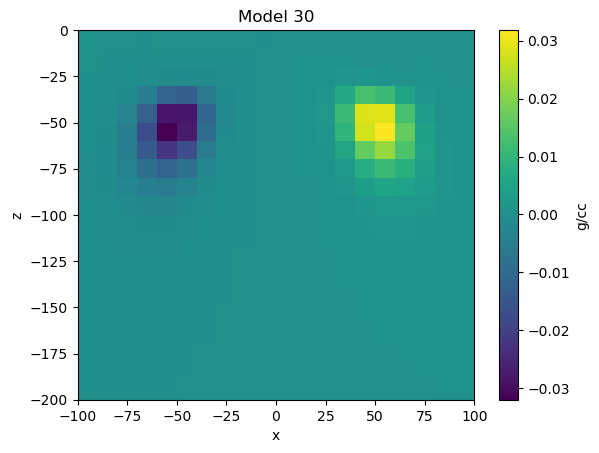

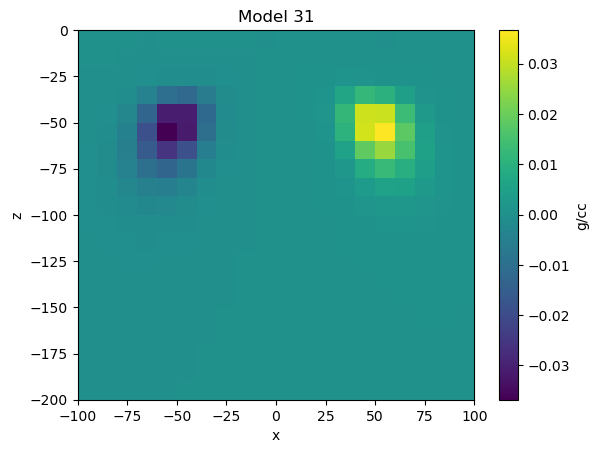

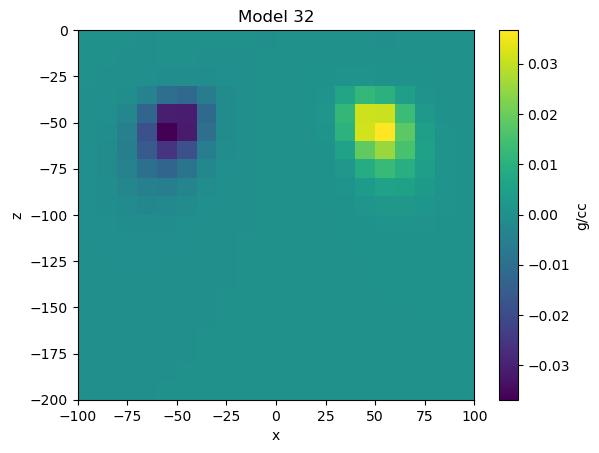

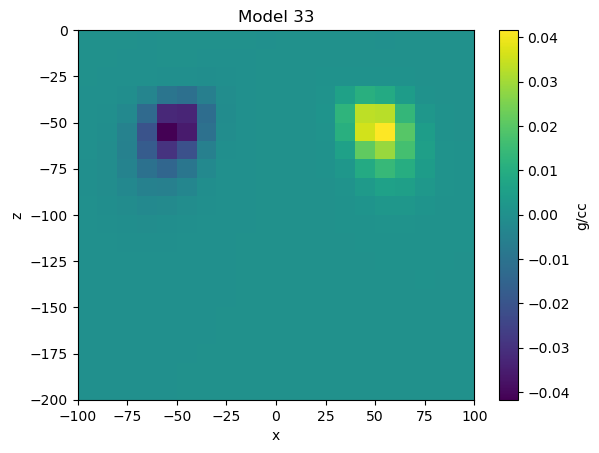

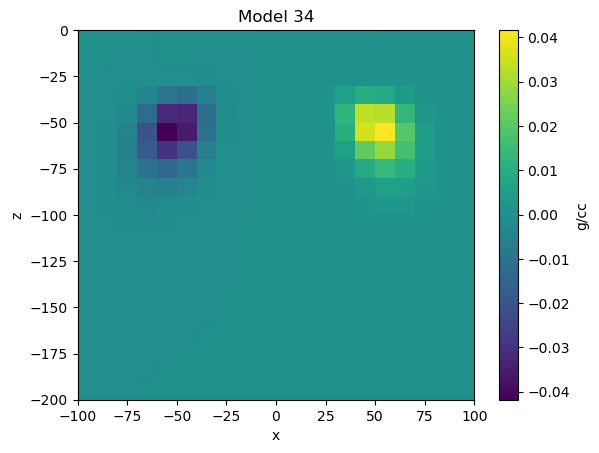

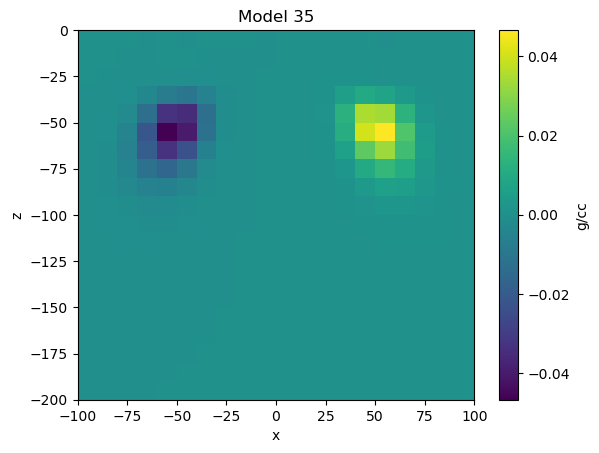

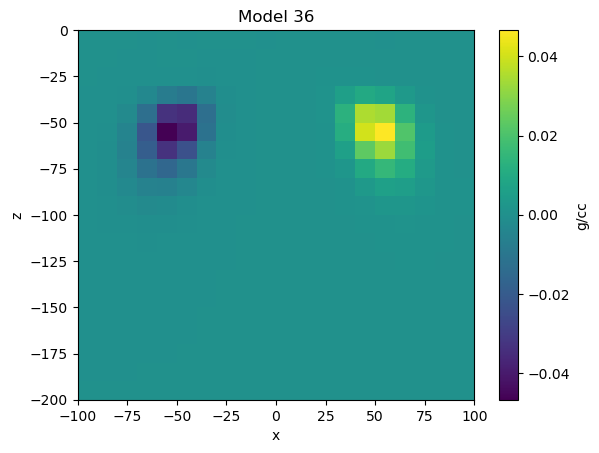

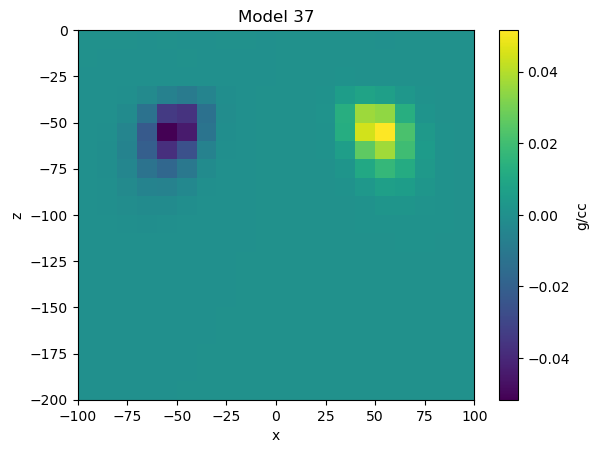

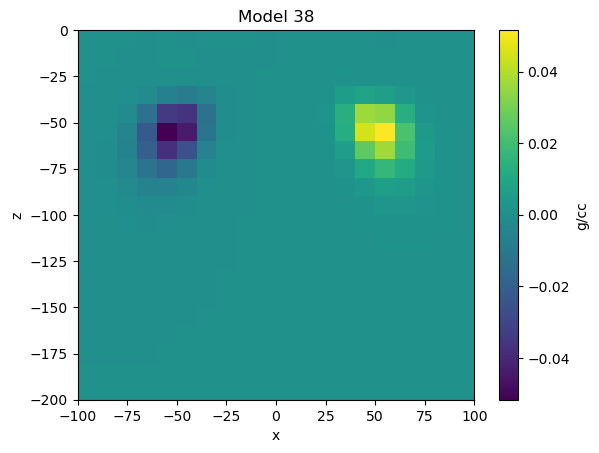

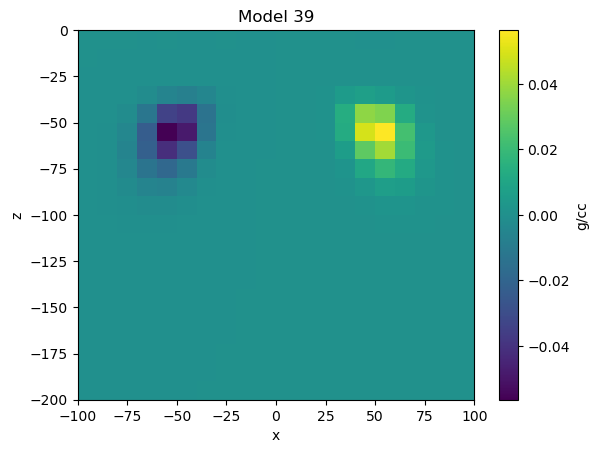

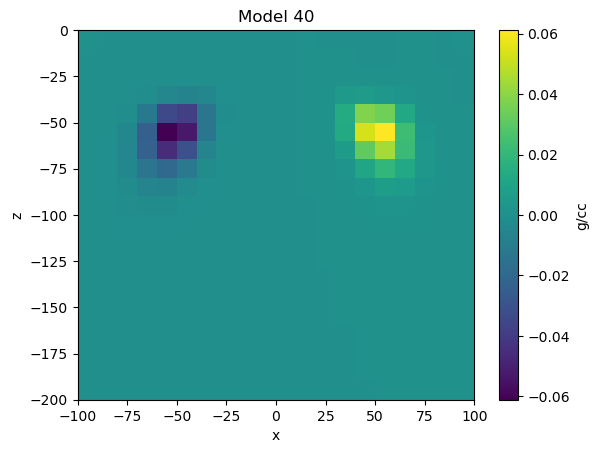

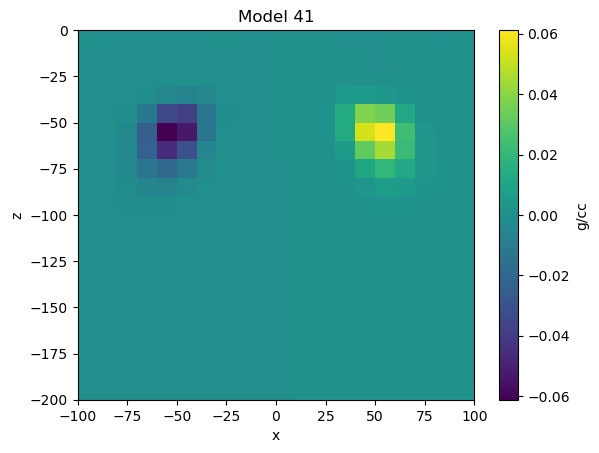

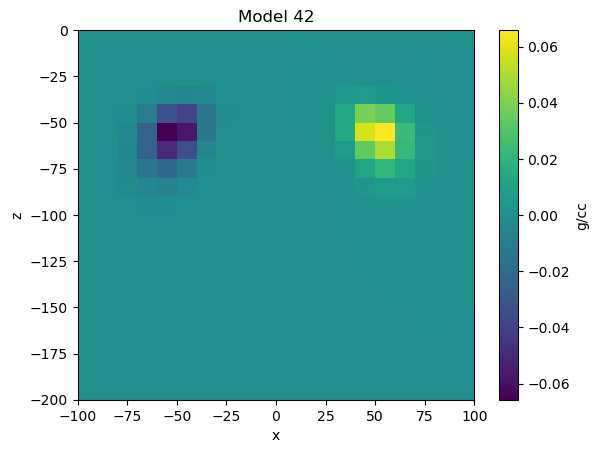

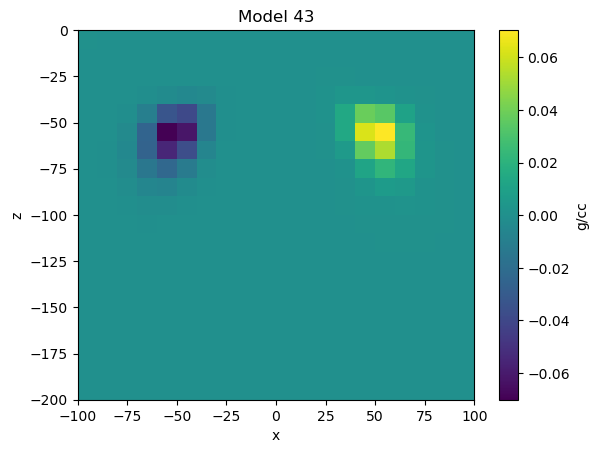

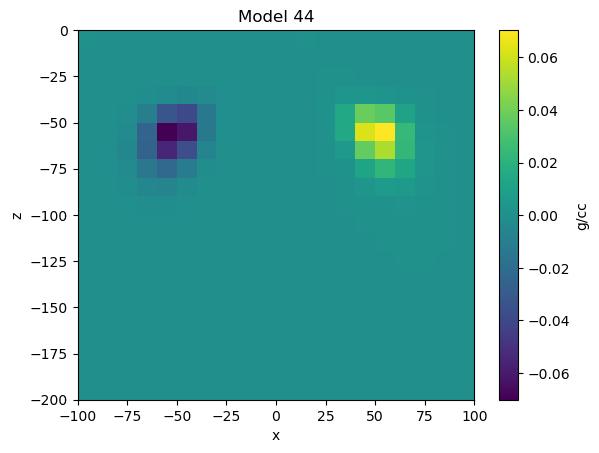

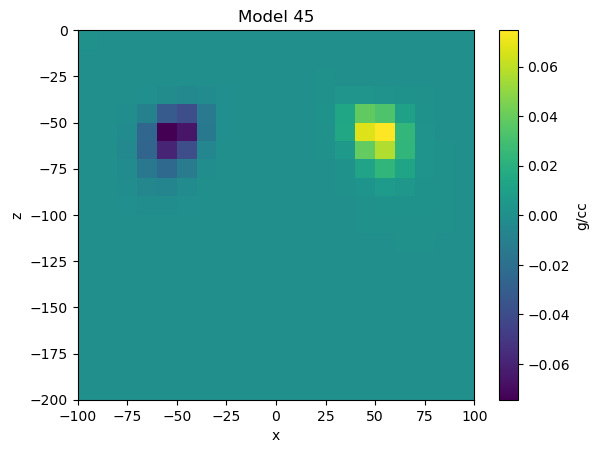

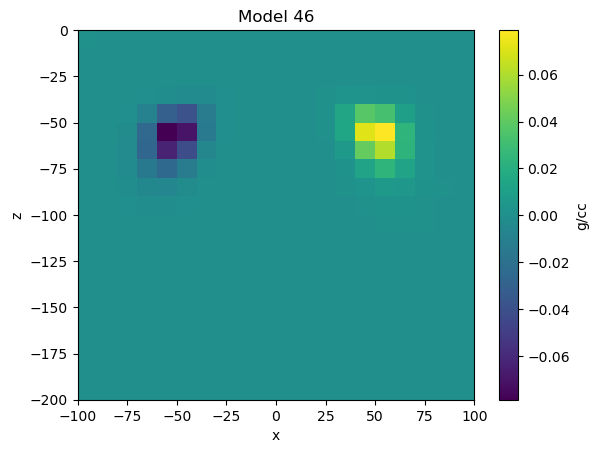

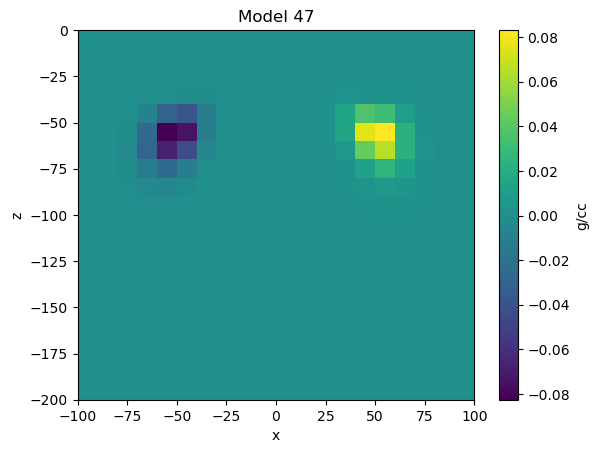

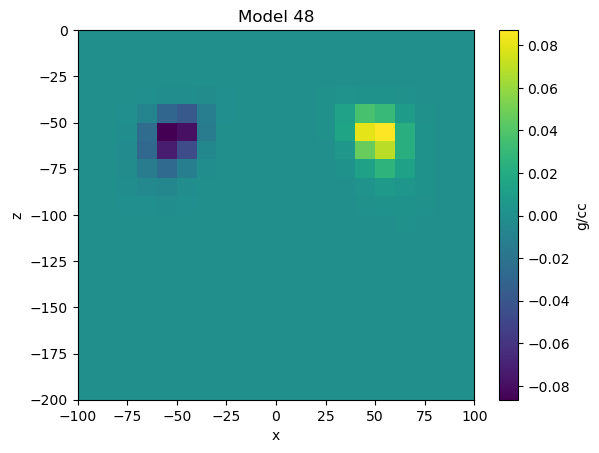

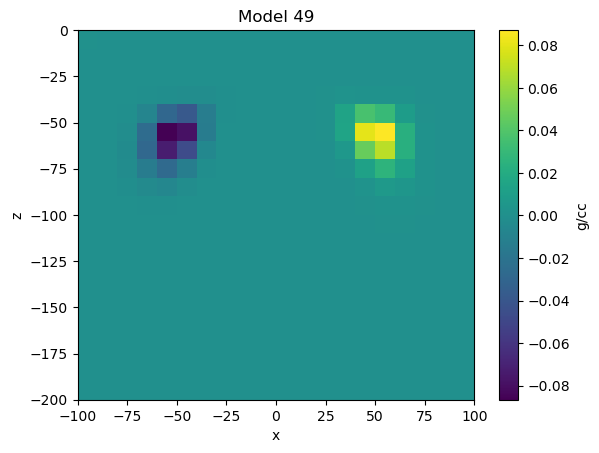

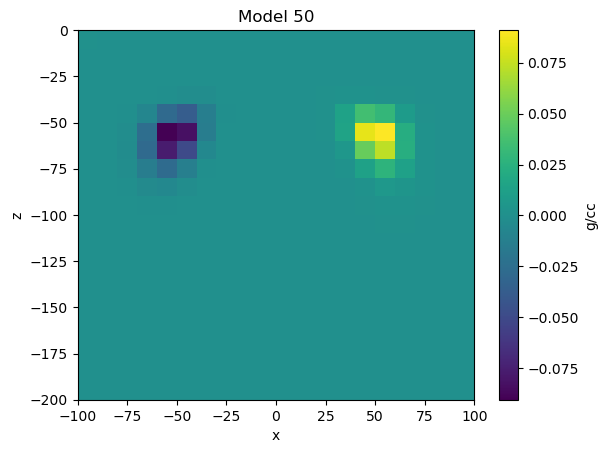

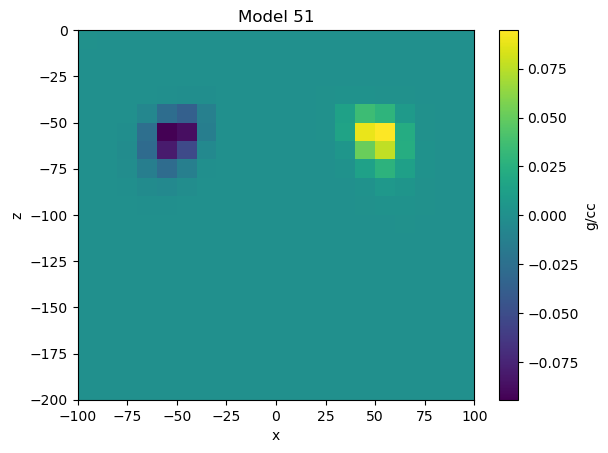

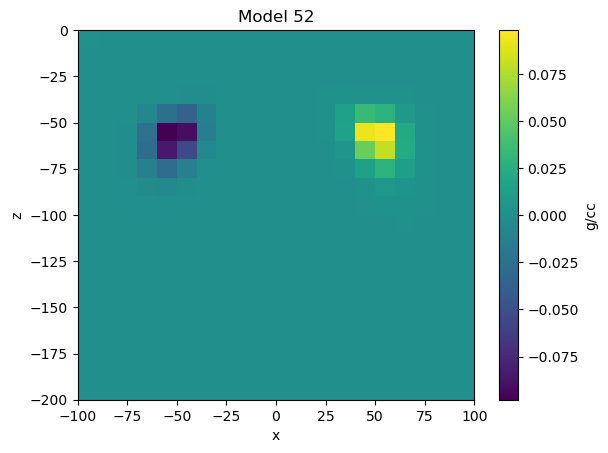

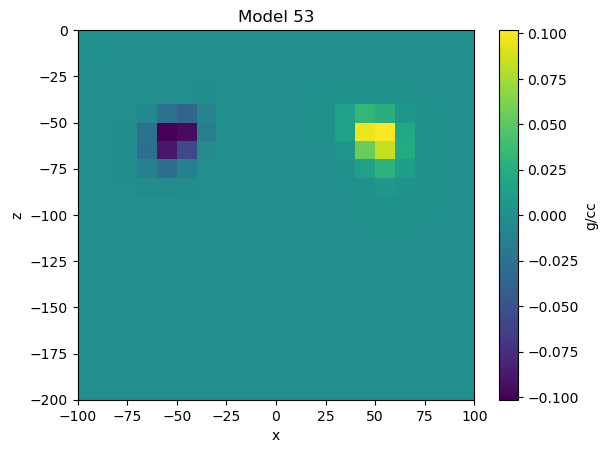

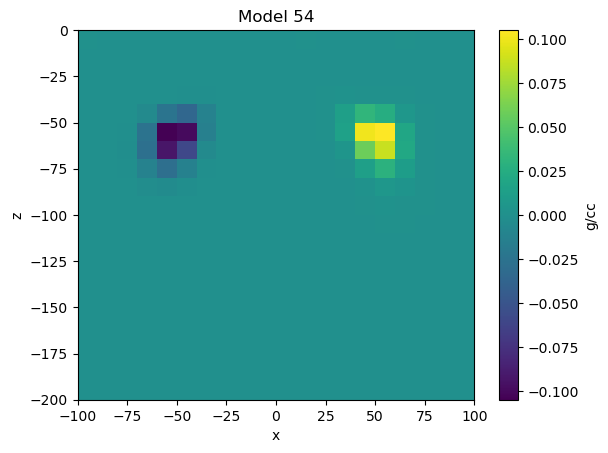

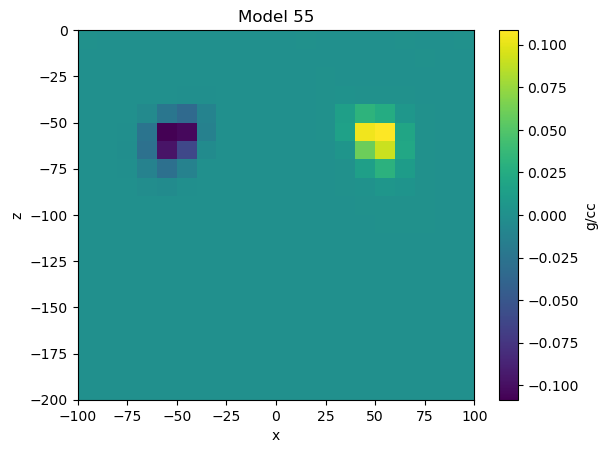

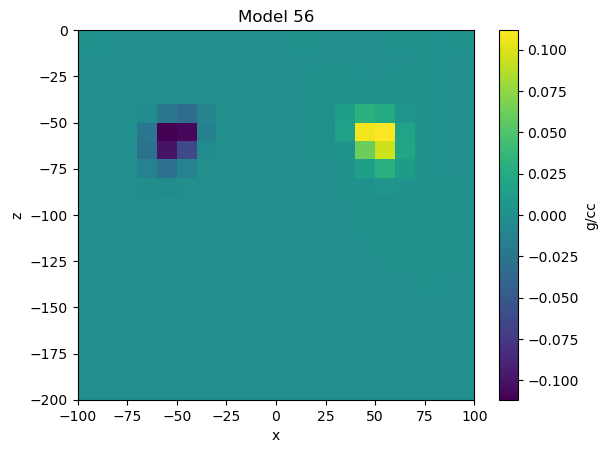

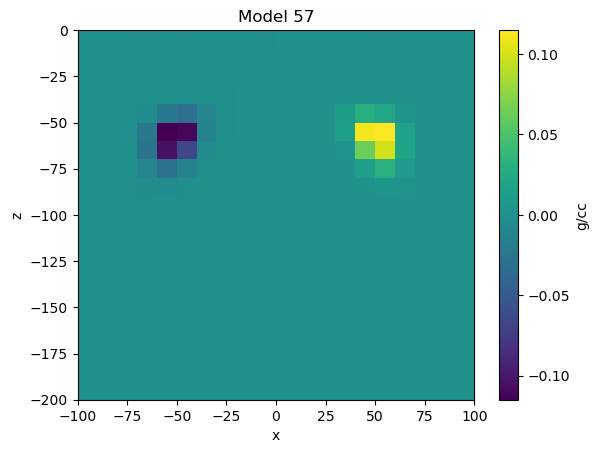

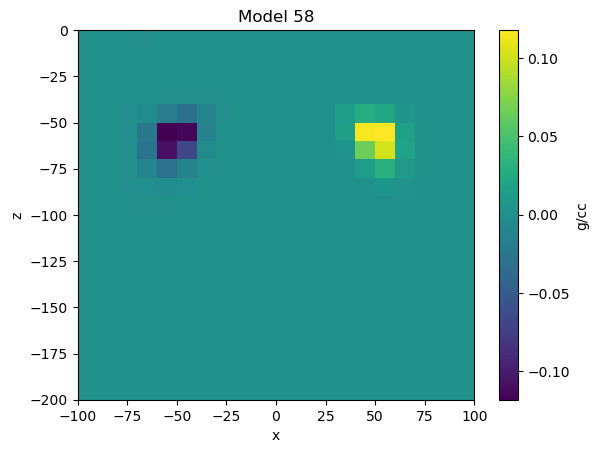

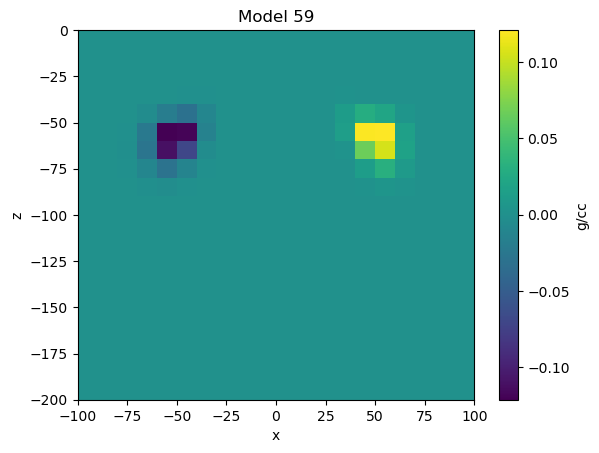

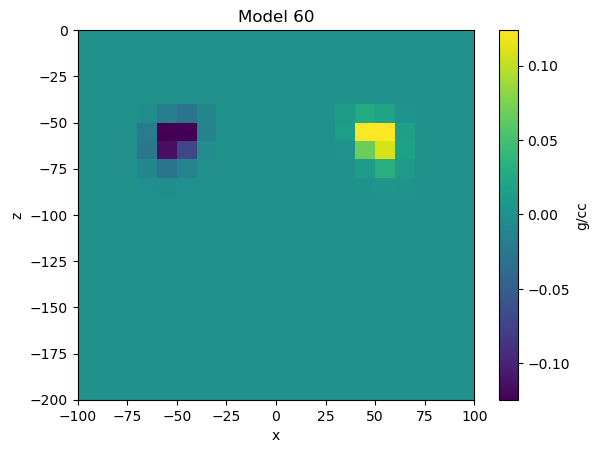

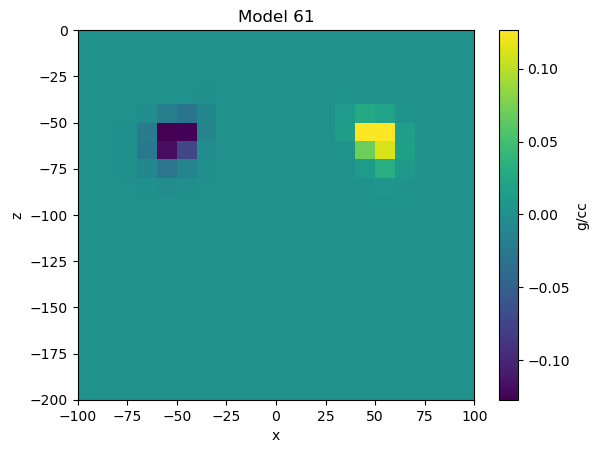

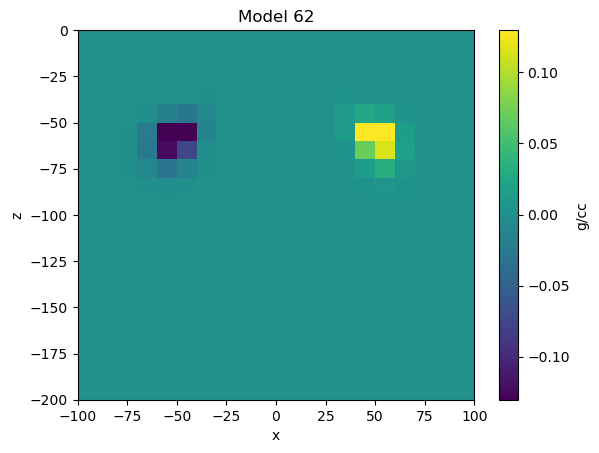

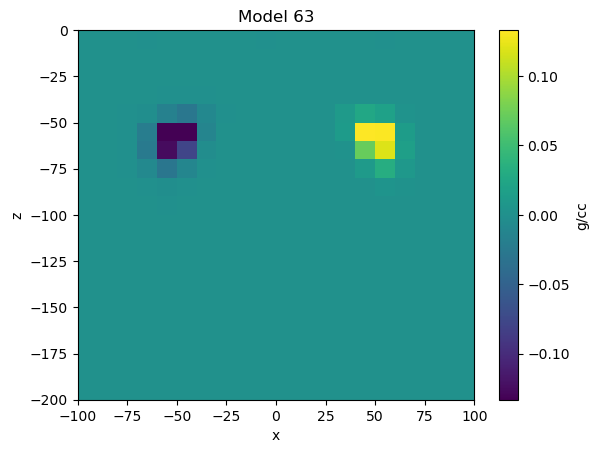

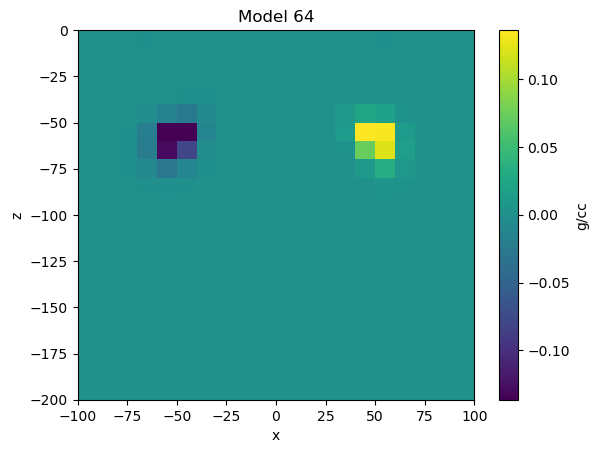

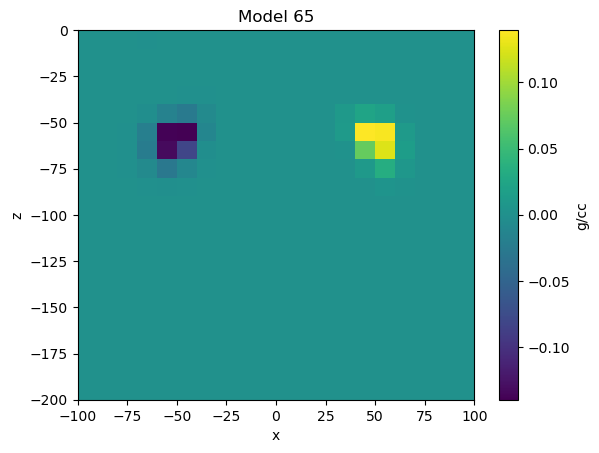

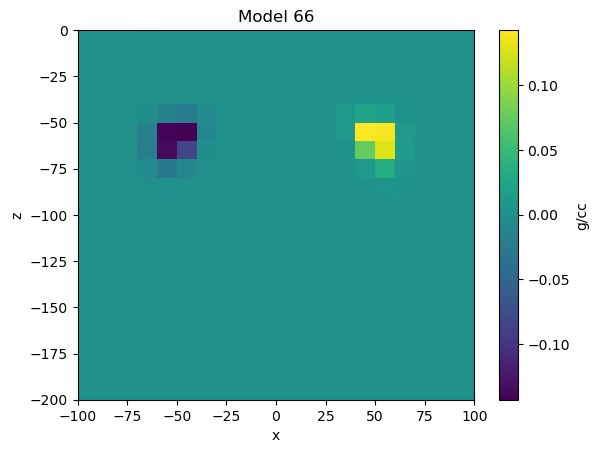

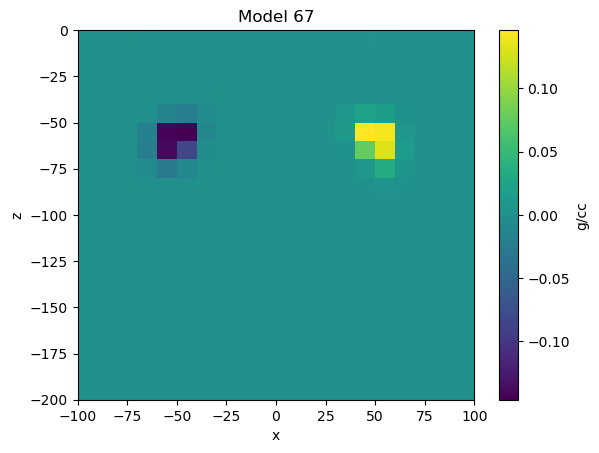

In [22]:
for i, model in enumerate(sparse_inversion.models):
    (tmp,) = mesh.plot_slice(model, normal="Y", slice_loc=0)
    plt.colorbar(tmp, label="g/cc")
    plt.title(f"Model {i}")
    plt.show()